#  "UJ SN2019 Zadanie 2: Nocne Ptasie Wędrówki"

## Basic information for audio analysis

### Spectogram
- visual representation of sound
- representation of the spectrum of frequencies of a signal as it varies over time

__Spectogram attributes__:
- time [s] on X asis
- frequency [Hz]  on Y axis
- amplitude as shading/intensity (colour refers to lower-higher amplitude)

__Example spectogram generation:__
- approximated as a filterbank that results from a series of band-pass filters (analog processing)
- calculated from the time signal using the Fourier transform (digital processing) <br>
These two methods actually form two different time–frequency representations, but are equivalent under some conditions.

## Data analysis and preprocessing for choosen recording
Note: Below analysis and preprocessing will be applied for one recording to visualize how it works. Then it will be applied to all recordings.

### Let's listen randomly choosen recording

In [1]:
import os
import IPython
filename = 'rec1.wav'
IPython.display.Audio(os.path.join('train', filename))

### Mel spectogram for recording
__Mel-scale__ - dependence between subjectively received pitch and objectively measured frequency in Hertz.

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Mel-Hz_plot.svg/2880px-Mel-Hz_plot.svg.png width="600">


Mel-scaled spectogram is generated using __librosa.feature.melspectrogram__. 
In my case, input to above function is a floating point time series representation. So that, spectrogram S is first computed, and then mapped onto the mel scale by __mel_f.dot(S**power)__. <br>
Filterbank matrix (an array of band-pass filters that separates the input signal into multiple components, each one carrying a single frequency sub-band of the original signal) is created to combine FFT bins into Mel-frequency bins.

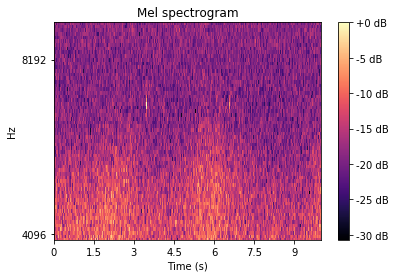

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

F_MIN = 4000
F_MAX = 9500


def load_recording(filename, train=True):
    if train:
        file_path = os.path.join('train', filename)
    else:
        file_path = os.path.join('test', filename)
    y, sample_rate = librosa.core.load(os.path.join('train', filename), sr=None)
    return y, sample_rate


def get_mel_spectogram(time_series_representation, sample_rate, start_second=0, end_second=10, n_mels=60):
    time_series_representation = time_series_representation[
                                 int(start_second * sample_rate):int(end_second * sample_rate)]
    mel_spectrogram = librosa.feature.melspectrogram(y=time_series_representation, sr=sample_rate, n_mels=n_mels,
                                                     fmin=F_MIN, fmax=F_MAX)
    return mel_spectrogram, sample_rate


def plot_mel_spectrogram(spectrogram, sample_rate):
    librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sample_rate, fmin=F_MIN, fmax=F_MAX,
                             y_axis='mel', x_axis='s')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')


y, sample_rate = load_recording(filename)
spectrogram, sample_rate = get_mel_spectogram(y, sample_rate)
plot_mel_spectrogram(spectrogram, sample_rate)

## Train and test data preparation

### IDEAS:
1. load spectogram for each recording and assign one-hot-encoded y (1 if bird exists, 0 otherwise) with size equal to 10 (possible problem: probabilities sum up to 1)
2. load spectogram and split it into 10 chunks (1 chunk for 1 second) and assing 1 if bird exists, 0 otherwise

In [3]:
def get_recording_with_list_of_seconds_where_bird_exist():
    rec_files = [filename for filename in os.listdir('train') if filename.endswith('.wav')]
    recordings = [filename.split(',')[0][:-4] for filename in rec_files]
    recording_second_mapping = {}
    for k in recordings:
        recording_second_mapping.setdefault(k, [])
    with open(os.path.join('train', 'labels.txt'), 'r') as f:
        for i, line in enumerate(f):
            if i != 0:
                recording_name = line.split(',')[0]
                start = int(float(line.split(',')[1]))
                stop = int(float(line.split(',')[2]))
                recording_second_mapping[recording_name].append(start)
                recording_second_mapping[recording_name].append(start)
    return recording_second_mapping

### First idea
Load spectogram for each recording and assign one-hot-encoded y (1 if bird exists, 0 otherwise) with size equal to 10 

In [4]:
def load_train():
    X_train, y_train = [], []
    N_SECONDS = 10
    recording_files = [filename for filename in os.listdir('train') if filename.endswith('.wav')]
    recording_second_mapping = get_recording_with_list_of_seconds_where_bird_exist()
    for recording_file in recording_files:
        # get spectogram representation of recording
        y, sample_rate = load_recording(recording_file)
        for sec in range(N_SECONDS):
            spectrogram, sample_rate = get_mel_spectogram(y, sample_rate, start_second=sec, end_second=sec + 1)
            X_train.append(spectrogram)
            if sec in recording_second_mapping[recording_file.split('.')[0]]:
                y_train.append(np.array([1]))
            else:
                y_train.append(np.array([0]))
    return np.array(X_train), np.array(y_train)


def load_test():
    X_test = []
    N_SECONDS = 10
    recording_files = [filename for filename in os.listdir('test') if filename.endswith('.wav')]
    for recording_file in recording_files:
        # get spectogram representation of recording
        y, sample_rate = load_recording(recording_file)
        for sec in range(N_SECONDS):
            spectrogram, sample_rate = get_mel_spectogram(y, sample_rate, start_second=sec, end_second=sec + 1)
            X_test.append(spectrogram)
    return np.array(X_test)


In [5]:
X_train, y_train = load_train()
X_test = load_test()

print(X_train.shape, y_train.shape)
print(X_train[0].shape, y_train[0].shape)
print(X_test[0].shape)

(3390, 60, 87) (3390, 1)
(60, 87) (1,)
(60, 87)


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
BATCH_SIZE = 64

dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

### Second idea
Load spectogram and split it into 10 chunks (1 chunk for 1 second) and assing 1 if bird exists, 0 otherwise

In [7]:
def load_train():
    X_train, y_train = [], []
    recording_files = [filename for filename in os.listdir('train') if filename.endswith('.wav')]
    recording_second_mapping = get_recording_with_list_of_seconds_where_bird_exist()
    for recording_file in recording_files:
        # get spectogram representation of recording
        y, sample_rate = load_recording(recording_file)
        spectrogram, sample_rate = get_mel_spectogram(y, sample_rate)
        # get one-hot-encoding 
        one_hot_encoded_y = np.zeros(10)
        for i in set(recording_second_mapping[recording_file.split('.')[0]]):
            one_hot_encoded_y[i] = 1
        # add to train data
        X_train.append(spectrogram)
        y_train.append(one_hot_encoded_y)
    return np.array(X_train), np.array(y_train)


def load_test():
    X_test = []
    recording_files = [filename for filename in os.listdir('test') if filename.endswith('.wav')]
    for recording_file in recording_files:
        # get spectogram representation of recording
        y, sample_rate = load_recording(recording_file)
        spectrogram, sample_rate = get_mel_spectogram(y, sample_rate)
        # add to test data
        X_test.append(spectrogram)
    return np.array(X_test)

In [8]:
X_train, y_train = load_train()
X_test = load_test()

print(X_train.shape, y_train.shape)
print(X_train[0].shape, y_train[0].shape)
print(X_test[0].shape)

(339, 60, 862) (339, 10)
(60, 862) (10,)
(60, 862)


In [9]:
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
BATCH_SIZE = 64

dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)